## EDA on NUGT, DUST, and GLD
Looking at the stocks related to gold prices.
Testing hypotheses:
* how correlated are these stocks?
* what are the biggest up/down moves for them?
* how well can we predict future prices?

In [1]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV as GSV
from sklearn.model_selection import ParameterGrid as PG
from sklearn.preprocessing import StandardScaler as SS
from sklearn.metrics import r2_score as r2
import time
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor as RFR
import sys
sys.path.append('../code')
import scrape_yahoo as sy
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import plotly
plotly.offline.init_notebook_mode()
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

In [3]:
sy.download_stocks()

https://ichart.yahoo.com/table.csv?s=GLD&a=0&b=0&c=0&d=05&e=14&f=2017
https://ichart.yahoo.com/table.csv?s=DUST&a=0&b=0&c=0&d=05&e=14&f=2017
https://ichart.yahoo.com/table.csv?s=NUGT&a=0&b=0&c=0&d=05&e=14&f=2017


In [4]:
dfs = sy.load_stocks()

In [5]:
dfs.keys()

dict_keys(['GLD', 'DUST', 'NUGT'])

In [6]:
NUGT = dfs['NUGT']
DUST = dfs['DUST']
GLD = dfs['GLD']

In [7]:
DUST.tail()

Open       High        Low      Close   Volume   Adj Close
Date                                                                       
2010-12-14  39.989999  40.569999  39.399999  40.149999   3300.0  950.648177
2010-12-13  39.619999  40.389999  39.129999  40.159999   3500.0  950.884951
2010-12-10  41.589999  42.299999  40.649999  40.909999  12300.0  968.643012
2010-12-09  40.719999  41.709999  40.689999  41.159999  14300.0  974.562365
2010-12-08  40.479999  42.019999  40.179999  41.639999   7500.0  985.927524

In [8]:
NUGT.head()

Open       High        Low      Close      Volume  Adj Close
Date                                                                         
2017-05-12  34.639999  35.290001  34.110001  34.610001  13731500.0  34.610001
2017-05-11  31.510000  33.540001  31.450001  33.130001  14379400.0  33.130001
2017-05-10  30.600000  31.530001  30.350000  31.110001  11527900.0  31.110001
2017-05-09  28.740000  29.559999  28.219999  29.450001  12369200.0  29.450001
2017-05-08  29.709999  29.719999  28.500000  29.629999  10141300.0  29.629999

In [9]:
te = NUGT.iloc[-1]

In [10]:
# stock is 1% of the original price
last_ratio = te['Close'] / te['Adj Close']
last_ratio

0.002600647972276549

In [11]:
NUGT = sy.normalize_prices(NUGT)
DUST = sy.normalize_prices(DUST)
GLD = sy.normalize_prices(GLD)

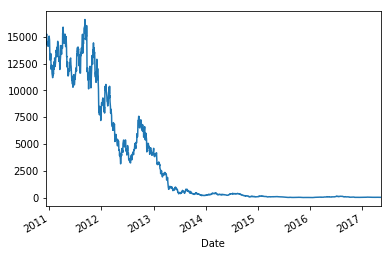

In [12]:
f = NUGT['Close'].plot()

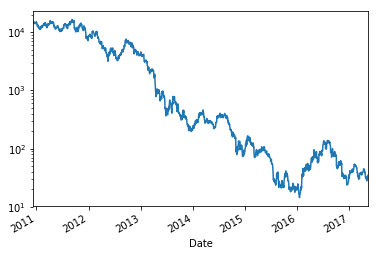

In [13]:
f = NUGT['Close'].plot()
ax = plt.gca()
ax.set_yscale('log')

## create some new features related to differences in price metrics

In [14]:
NUGT = sy.create_new_features(NUGT)
DUST = sy.create_new_features(DUST)
GLD = sy.create_new_features(GLD)

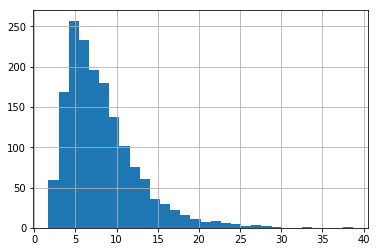

In [15]:
f = NUGT['high-low_pct'].hist(bins=30)

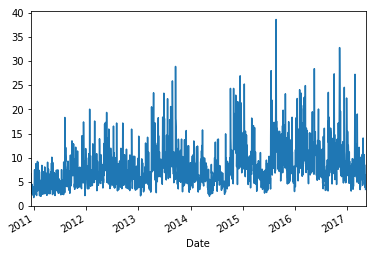

In [16]:
NUGT['high-low_pct'].plot()

Hmm... volatility increasing?

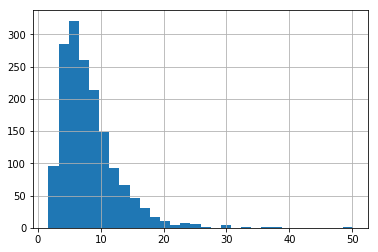

In [17]:
f = DUST['high-low_pct'].hist(bins=30)

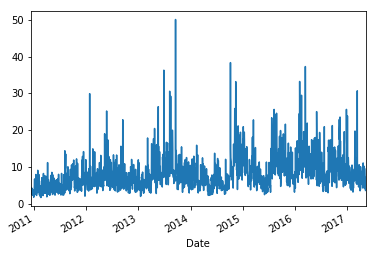

In [18]:
f = DUST['high-low_pct'].plot()

In [19]:
f = iplot([{'x':DUST.index, 'y':DUST['high-low_pct']}])

In [20]:
f = iplot([{'x':DUST.index, 'y':DUST['close-open_pct']}])

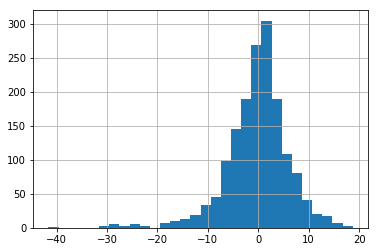

In [21]:
f = DUST['close-open_pct'].hist(bins=30)

Looks like we have a fat tail on the downside.  Only a few days with major downdraws, but good to know.

In [22]:
DUST['close-open_pct'].mean()

-0.16657714217657732

In [23]:
DUST['close-open_pct'].median()

0.3307122593202729

# Question:
What is the probability that if we had a down day, the next day will be down? Up? And vice-versa?

In [24]:
down_days = DUST[DUST['close-open_pct'] < 0]

In [25]:
down_days.index

DatetimeIndex(['2017-05-12', '2017-05-11', '2017-05-10', '2017-05-09',
               '2017-05-05', '2017-05-02', '2017-04-28', '2017-04-26',
               '2017-04-24', '2017-04-20',
               ...
               '2011-01-20', '2011-01-18', '2011-01-11', '2011-01-10',
               '2011-01-07', '2010-12-31', '2010-12-28', '2010-12-23',
               '2010-12-20', '2010-12-10'],
              dtype='datetime64[ns]', name='Date', length=767, freq=None)

In [26]:
after_days = DUST.ix[down_days.index + pd.Timedelta('1 days')]

In [27]:
after_days.shape

(767, 10)

In [28]:
down_days.shape

(767, 10)

In [29]:
DUST.shape

(1618, 10)

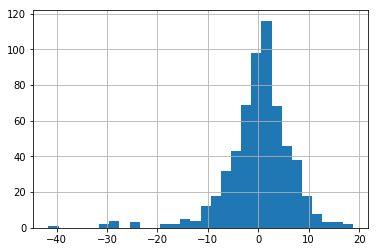

In [30]:
f = after_days['close-open_pct'].hist(bins=30)

Distribution looks the same as the overall distribution.

# Next step:
* find if after 2, or 3 up or down days in a row, if higher probability of another type of movement.

# generate simple time-lagged feature
Question: based on a week of data, can we predict the price one week in the future?  E.g., given data from M-F, can we predict the close price next Friday?



I suppose a good question to ask would be can we predict large movements up or down one week out in the future?

In [31]:
# set hyperparameters
history_days = 5  # number of days to use for prediction
future_days = 5  # days out in the future we want to predict for
data_points = NUGT.shape[0]

In [32]:
NUGT = NUGT.iloc[::-1]  # reverses dataframe

In [33]:
# create time-lagged features
features = []
targets = []
for i in range(history_days, data_points - future_days):
    features.append(NUGT.iloc[i - history_days:i][['Open', 'High', 'Low', 'Close', 'Volume']].values.ravel())
    targets.append(NUGT.iloc[i + future_days]['Close'])

features = np.array(features)
targets = np.array(targets)

In [34]:
# split into train/test sets
features.shape

(1608, 25)

In [35]:
train_size = int(0.75 * features.shape[0])

In [36]:
train_size

1206

In [37]:
train_f = features[:train_size]
test_f = features[train_size:]
train_t = targets[:train_size]
test_t = targets[train_size:]

In [38]:
rf = RFR(n_estimators=300, n_jobs=-1)

In [39]:
rf.fit(train_f, train_t)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=300, n_jobs=-1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [40]:
rf.score(test_f, test_t)

0.68583847111937291

In [41]:
preds = rf.predict(test_f)

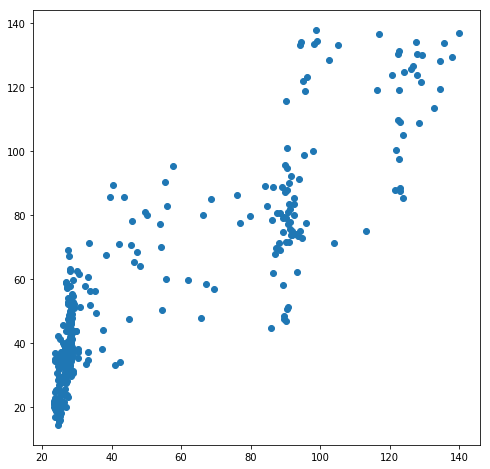

In [42]:
f = plt.figure(figsize=(8, 8))
f = plt.scatter(preds, test_t)

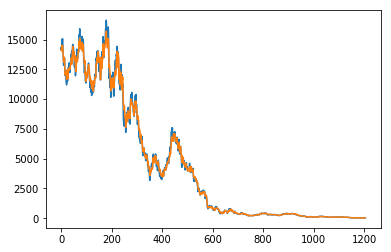

In [45]:
f = plt.plot(train_t)
f = plt.plot(rf.predict(train_f))

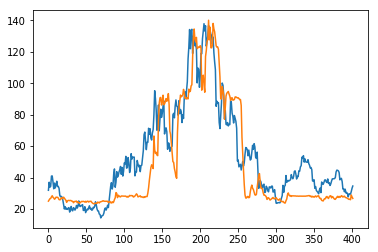

In [46]:
f = plt.plot(test_t)
f = plt.plot(preds)

In [45]:
reg = xgb.XGBRegressor()

In [55]:
start = time.time()
reg.fit(train_f, train_t)
end = time.time()

In [56]:
end-start

2.1833786964416504

In [71]:
parameters = {'max_depth':[3, 4, 5, 6],
              'learning_rate':[0.1, 0.01, 0.001],
              'n_estimators':[100, 200, 300, 400, 500, 600],
              'subsample':[0.4],
              'seed':[42]}

In [72]:
start = time.time()
scores = []
params = []
models = []
best_score = -float("inf")
for g in PG(parameters):
    reg = xgb.XGBRegressor(**g)
    reg.fit(train_f, train_t)
    score = r2(test_t, reg.predict(test_f))
    models.append(reg)
    params.append(g)
    scores.append(score)
    if score > best_score:
        best_score = score
        best_grid = g
        best_model = reg

end = time.time()

In [73]:
end - start

69.39004898071289

In [74]:
best_grid

{'learning_rate': 0.01,
 'max_depth': 6,
 'n_estimators': 400,
 'seed': 42,
 'subsample': 0.4}

In [75]:
best_score

0.72594018316061892

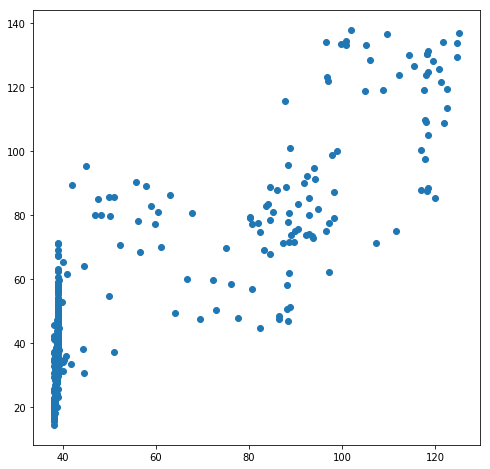

In [77]:
f = plt.figure(figsize=(8, 8))
f = plt.scatter(best_model.predict(test_f), test_t)

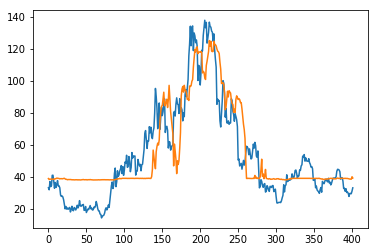

In [80]:
plt.plot(test_t)
plt.plot(best_model.predict(test_f))

# hmm...need to scale first.  It's obviously fitting the big numbers, but not the small ones

In [129]:
train_scaler = SS()

In [130]:
# annoyingly have to reshape...
scaled_train_t = train_scaler.fit_transform(train_t.reshape(-1, 1))

In [131]:
scaled_train_f = []
for i in range(train_f.shape[1]):
    scaled_train_fi = train_scaler.transform(train_f[:, i].reshape(-1, 1))
    scaled_train_f.append(scaled_train_fi)

scaled_train_f = np.array(scaled_train_f)[:,:,0].T

In [132]:
test = train_scaler.inverse_transform(scaled_train_f[:, 0].reshape(-1, 1))

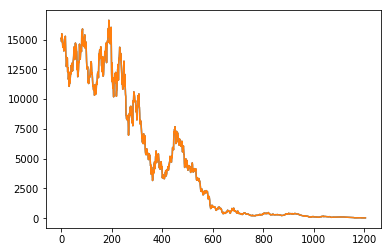

In [133]:
plt.plot(test)
plt.plot(train_f[:, 0])

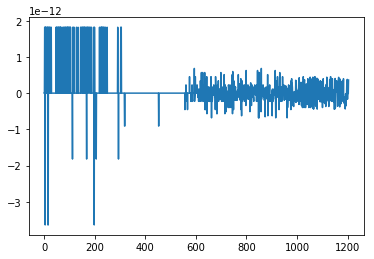

In [134]:
plt.plot(test[:, 0] - train_f[:, 0])

ok, convinced that the scaling is all working out well

In [135]:
scaled_test_t = train_scaler.transform(test_t.reshape(-1, 1))
scaled_test_f = []
for i in range(test_f.shape[1]):
    scaled_test_fi = train_scaler.transform(test_f[:, i].reshape(-1, 1))
    scaled_test_f.append(scaled_test_fi)

scaled_test_f = np.array(scaled_test_f)[:,:,0].T

In [136]:
start = time.time()
scores = []
params = []
models = []
best_score = -float("inf")
for g in PG(parameters):
    reg = xgb.XGBRegressor(**g)
    reg.fit(scaled_train_f, scaled_train_t)
    score = r2(scaled_test_t, reg.predict(scaled_test_f))
    models.append(reg)
    params.append(g)
    scores.append(score)
    if score > best_score:
        best_score = score
        best_grid = g
        best_model = reg

end = time.time()

In [137]:
end - start

258.5148272514343

In [138]:
best_score

0.73324615088435041

In [139]:
best_grid

{'learning_rate': 0.1,
 'max_depth': 5,
 'n_estimators': 300,
 'seed': 42,
 'subsample': 0.4}

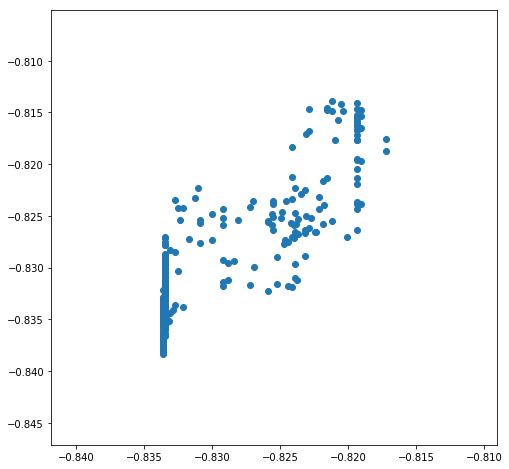

In [143]:
f = plt.figure(figsize=(8, 8))
f = plt.scatter(best_model.predict(scaled_test_f), scaled_test_t)

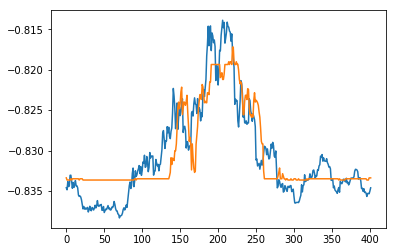

In [145]:
plt.plot(scaled_test_t)
plt.plot(best_model.predict(scaled_test_f))

In [146]:
from sklearn.preprocessing import MinMaxScaler

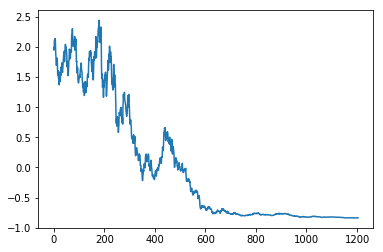

In [147]:
plt.plot(scaled_train_t)

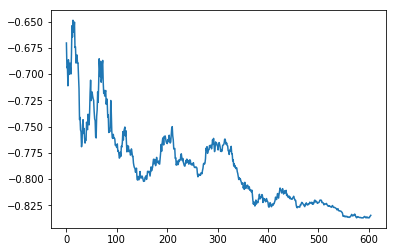

In [148]:
plt.plot(scaled_train_t[600:])

In [149]:
scaler = MinMaxScaler(feature_range=(0, 1))

In [151]:
t = scaler.fit_transform(train_t.reshape(-1, 1))

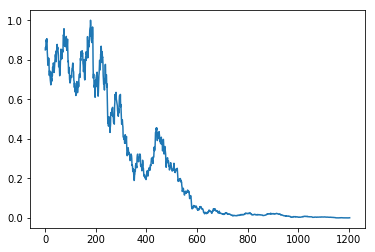

In [152]:
plt.plot(t)

# todo:
need to scale the data in a better way.
ideas:
* break into chunks of data where each chunk has a certain range (like += 20%)
* convert into % difference from day before -- need to build a custom scaler
* subtract some long-term moving average

In [73]:
DUST.head()

Open       High        Low      Close     Volume  Adj Close  \
Date                                                                           
2017-05-12  29.900000  30.320000  29.240000  29.820000  7340900.0  29.820000   
2017-05-11  32.939999  33.009998  30.780001  31.209999  6837600.0  31.209999   
2017-05-10  33.930000  34.270000  32.849998  33.299999  6094700.0  33.299999   
2017-05-09  36.299999  36.840000  35.169998  35.360001  7235000.0  35.360001   
2017-05-08  35.119999  36.500000  35.080002  35.220001  5312200.0  35.220001   

            close-open  high-low  close-open_pct  high-low_pct  
Date                                                            
2017-05-12   -0.080000  1.080000       -0.268276      3.621730  
2017-05-11   -1.730000  2.229997       -5.543095      7.145136  
2017-05-10   -0.630001  1.420002       -1.891895      4.264270  
2017-05-09   -0.939998  1.670002       -2.658365      4.722856  
2017-05-08    0.100002  1.419998        0.283935      4.031794

In [74]:
close_rolling_mean = DUST['Close'].rolling(20).mean()

In [75]:
# need to fill in first points because they are NANs.  fill with closest point (backfilling I think?)
close_rolling_mean.iloc[:19] = close_rolling_mean.iloc[19]

In [76]:
close_rolling_mean.iloc[:20]

Date
2017-05-12    31.7935
2017-05-11    31.7935
2017-05-10    31.7935
2017-05-09    31.7935
2017-05-08    31.7935
2017-05-05    31.7935
2017-05-04    31.7935
2017-05-03    31.7935
2017-05-02    31.7935
2017-05-01    31.7935
2017-04-28    31.7935
2017-04-27    31.7935
2017-04-26    31.7935
2017-04-25    31.7935
2017-04-24    31.7935
2017-04-21    31.7935
2017-04-20    31.7935
2017-04-19    31.7935
2017-04-18    31.7935
2017-04-17    31.7935
Name: Close, dtype: float64

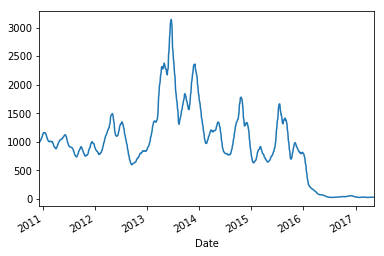

In [78]:
f = close_rolling_mean.plot()

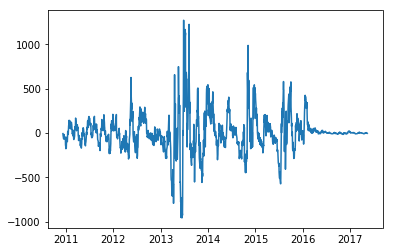

In [79]:
f = plt.plot(DUST['Close'] - close_rolling_mean)

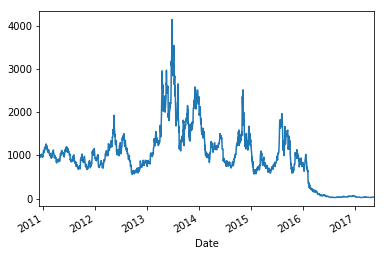

In [80]:
f = DUST['Close'].plot()

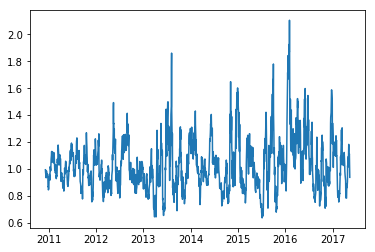

In [81]:
f = plt.plot(DUST['Close'] / close_rolling_mean)

In [82]:
close_scaler = SS()

In [83]:
mva_scaled_close = DUST['Close'] / close_rolling_mean

In [84]:
type(mva_scaled_close.values)

numpy.ndarray

In [91]:
scaled_close = close_scaler.fit_transform(mva_scaled_close.values.reshape(-1, 1))

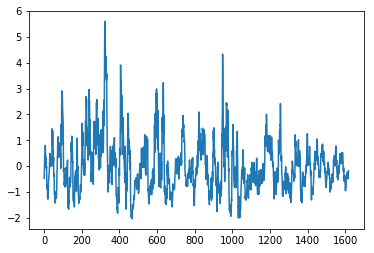

In [92]:
# looks a lot better...but why is it reversed?!
f = plt.plot(scaled_close)

In [87]:
# let's see if we can reverse it sufficiently
unscaled_close = close_scaler.inverse_transform(scaled_close)

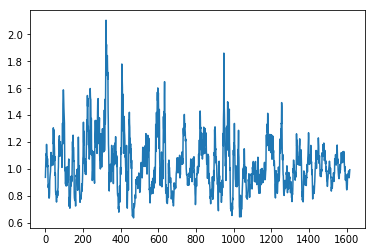

In [88]:
f = plt.plot(unscaled_close)

In [71]:
orig_close = unscaled_close[:, 0] * close_rolling_mean.values

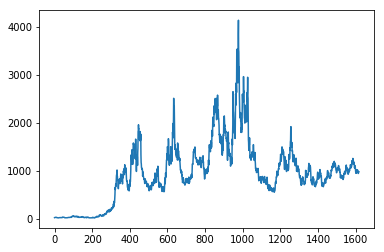

In [72]:
f = plt.plot(orig_close)

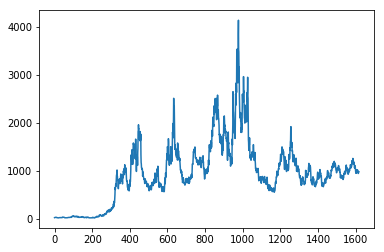

In [94]:
f = plt.plot(DUST['Close'].values)

In [95]:
np.allclose(DUST['Close'].values, orig_close)

True

In [132]:
# write a function to do all that
def transform_data(data, mva=20):
    """
    Takes a numpy array as input, divides by a moving average with period mva (integer),
    and returns the scaled data as well as the scaler 
    and moving average (needed for returning the data to its original form).
    Todo in the future: make a class for this so the scaler can be stored in there.
    """
    rolling_mean = pd.Series(data).rolling(window=mva).mean()
    rolling_mean.iloc[:mva - 1] = rolling_mean.iloc[mva - 1]  # fill in missing values at the beginning
    mva_scaled = data / rolling_mean
    scaler = SS()
    scaled = scaler.fit_transform(mva_scaled.values.reshape(-1, 1))
    return scaled.ravel(), scaler, rolling_mean

In [143]:
def transform_more_data(data, scaler, mva=20):
    """
    Takes a numpy array (data) a standardscaler, and moving average data set as input, 
    divides by the moving average and uses the scaler to scale it,
    and returns the scaled data.
    """
    rolling_mean = pd.Series(data).rolling(window=mva).mean()
    rolling_mean.iloc[:mva - 1] = rolling_mean.iloc[mva - 1]  # fill in missing values at the beginning
    mva_scaled = data / rolling_mean
    scaled = scaler.transform(mva_scaled.values.reshape(-1, 1))
    return scaled.ravel(), rolling_mean

In [119]:
scaled, scaler, rolling_mean = transform_data(DUST['Close'].values)

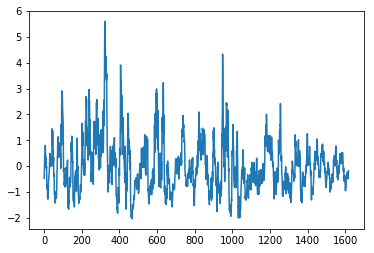

In [120]:
f = plt.plot(scaled)

In [125]:
def reform_data(data, scaler, rolling_mean):
    """
    Re-constructs original data from the transformed data.  Requires the same scaler and rolling mean
    from transforming the data to do so.
    """
    unscaled = scaler.inverse_transform(data)
    unrolled = unscaled * rolling_mean
    return unrolled

In [126]:
orig = reform_data(scaled, scaler, rolling_mean)

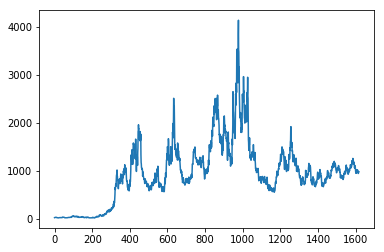

In [128]:
f = plt.plot(orig)

In [129]:
np.allclose(orig, DUST['Close'].values)

True

# Try scaling the data with these functions, then using xgboost again

In [145]:
# first the targets
scaled_train_t, train_t_scaler, train_t_mva = transform_data(train_t)
scaled_train_f = []
train_f_scalers = []
train_f_mvas = []
for i in range(train_f.shape[1]):
    scaled_train_fi, scaler, mva = transform_data(train_f[:, i])
    scaled_train_f.append(scaled_train_fi)
    train_f_scalers.append(scaler)
    train_f_mvas.append(mva)

scaled_train_f = np.array(scaled_train_f).T

In [146]:
scaled_test_t, test_t_mva = transform_more_data(test_t, train_t_scaler)
scaled_test_f = []
test_f_mvas = []
for i in range(test_f.shape[1]):
    scaled_test_fi, mva = transform_more_data(test_f[:, i], train_f_scalers[i])
    scaled_test_f.append(scaled_test_fi)
    test_f_mvas.append(mva)

scaled_test_f = np.array(scaled_test_f).T

In [159]:
params = {'learning_rate': 0.01,
 'max_depth': 3,
 'n_estimators': 400,
 'seed': 42,
 'subsample': 0.4}

In [160]:
reg = xgb.XGBRegressor()

In [161]:
start = time.time()
reg.fit(scaled_train_f, scaled_train_t)
end = time.time()

In [162]:
end - start

2.959780693054199

In [163]:
preds = reg.predict(scaled_test_f)

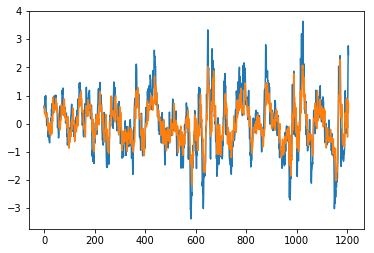

In [165]:
plt.plot(scaled_train_t)
plt.plot(reg.predict(scaled_train_f))

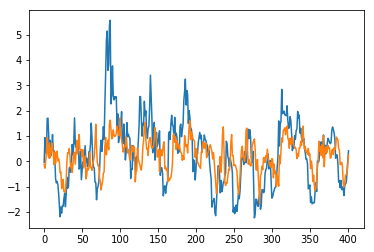

In [164]:
plt.plot(scaled_test_t)
plt.plot(preds)

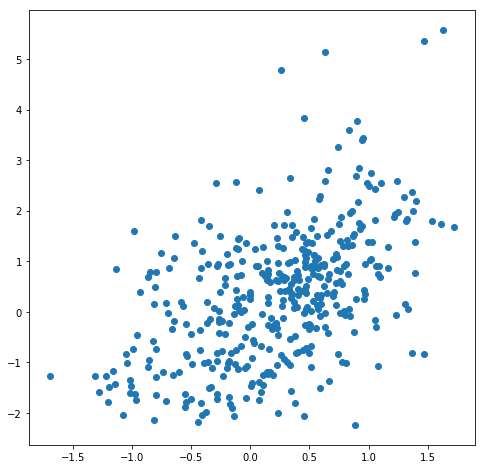

In [166]:
f = plt.figure(figsize=(8, 8))
f = plt.scatter(reg.predict(scaled_test_f), scaled_test_t)

In [167]:
r2(scaled_test_t, reg.predict(scaled_test_f))

0.2516133217507992

In [168]:
parameters = {'max_depth':[3, 4, 5, 6],
              'learning_rate':[0.1, 0.01, 0.001],
              'n_estimators':[100, 200, 300, 400, 500, 600],
              'subsample':[0.4],
              'seed':[42]}

In [169]:
start = time.time()
scores = []
params = []
models = []
best_score = -float("inf")
for g in PG(parameters):
    reg = xgb.XGBRegressor(**g)
    reg.fit(scaled_train_f, scaled_train_t)
    score = r2(scaled_test_t, reg.predict(scaled_test_f))
    models.append(reg)
    params.append(g)
    scores.append(score)
    if score > best_score:
        best_score = score
        best_grid = g
        best_model = reg

end = time.time()

In [170]:
end - start

395.67286705970764

In [171]:
best_score

0.29010755719950498

In [172]:
best_grid

{'learning_rate': 0.01,
 'max_depth': 3,
 'n_estimators': 400,
 'seed': 42,
 'subsample': 0.4}

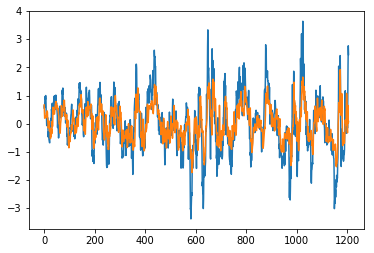

In [173]:
plt.plot(scaled_train_t)
plt.plot(best_model.predict(scaled_train_f))

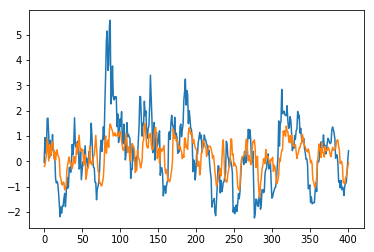

In [176]:
plt.plot(scaled_test_t)
plt.plot(best_model.predict(scaled_test_f))

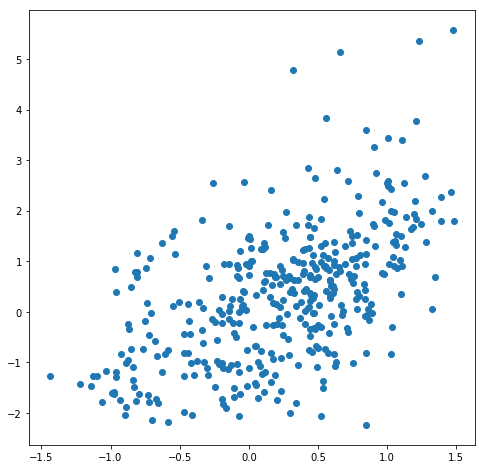

In [175]:
f = plt.figure(figsize=(8, 8))
f = plt.scatter(best_model.predict(scaled_test_f), scaled_test_t)

# next todos:
* use a longer time history (20-30 days)
* use lstm neural net with keras

# things to check next:
* number of upmoves/downmoves in a row
* create close-last_close col